In [2]:
%load_ext autoreload
%autoreload 2

# Classification Task using the Original MNIST Data
The purpose of this notebook is to get a baseline accuracy for the original MNIST images. This is so that we cam compare performance of our methods later. 

In [3]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#from scipy.fft import fft2, ifft2, fft, ifft

import torchvision.transforms as transforms
from torchvision import datasets
import torch
import sklearn
import wandb

desktop_path = '/Users/jocelynornelasmunoz/Desktop/Research/coded-aperture/jornelasmunoz/'
laptop_path = '/Users/jocelynornelas/iCloud Drive (Archive)/Desktop/UC Merced/Research/coded-aperture/jornelasmunoz/'
if desktop_path in sys.path[0]: sys.path.insert(0, desktop_path + 'lib/'); path = desktop_path
elif laptop_path in sys.path[0]: sys.path.insert(0, laptop_path + 'lib/'); path = laptop_path
print('Using path = ', path)

import MURA as mura
from CNN import CNN
import confusion_matrix as cm

Using path =  /Users/jocelynornelas/iCloud Drive (Archive)/Desktop/UC Merced/Research/coded-aperture/jornelasmunoz/


In [4]:
# Change plotting parameters
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Times", #"Computer Modern Serif"
    "figure.figsize" : [15,10],
})

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Log into WandB
wandb.login()

Using cpu device


wandb: Currently logged in as: jocelynornelasmunoz. Use `wandb login --relogin` to force relogin


True

# Load MNIST Data

In [6]:
%%time
# define hyperparameters
params = {
  "dataset": "MNIST- original",
 # "machine": "desktop",
  "model": "OG_classification",
  "learning_rate": 1e-3,
  "batch_size": 100,
  "epochs": 50,
  "kernel_size":3,
  "p": 23, # size of array (has to be prime)
  "image_size": 23
}
wandb.config = params

# Compute MURA encoder and decoder
params['A'] = mura.create_binary_aperture_arr(params['p'])
params['G'] = mura.create_decoding_arr(params['A'])

CPU times: user 1.92 ms, sys: 72 µs, total: 2 ms
Wall time: 1.98 ms


In [7]:
# define CNN and get data
model = CNN().to(device)
train_data, test_data = model._get_dataset(params['A'], encoded=False)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3) 
PATH = f'../models/{params["model"]}_mnist_{params["epochs"]}epochs.pth'

In [8]:
loaders = {
    'train' : torch.utils.data.DataLoader(train_data, 
                                          batch_size=params['batch_size'], 
                                          shuffle=True, 
                                          num_workers=0),
    
    'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=params['batch_size'], 
                                          shuffle=False, 
                                          num_workers=0),
}

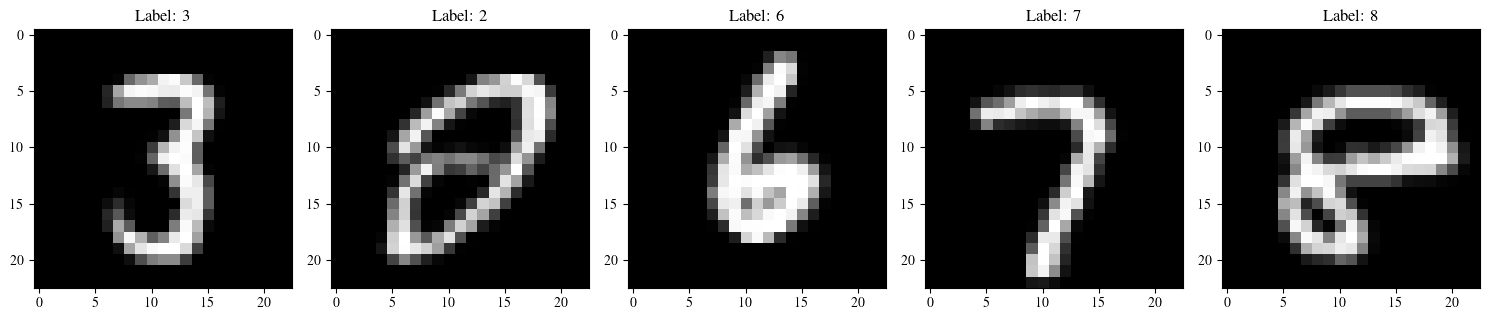

In [9]:
# Printing 25 random images from the training dataset
random_samples = np.random.randint(1, len(train_data), (5))
count = 0
for idx in random_samples: #range(random_samples.shape[0]):
    plt.subplot(1, 5, count + 1)
    plt.imshow(train_data[idx][0][0].numpy(), cmap='gray')
    #plt.colorbar()
    plt.title(f'Label: {train_data[idx][1]}')
    # plt.subplot(2, 5, count + 6)
    # plt.imshow(train_data[idx][1][0].numpy(), cmap='gray')
    # plt.title('Original image')
    # plt.axis('off')
    
    count += 1
plt.tight_layout()
plt.show()

## Train

In [20]:
wandb.init(project="coded-aperture-MNIST", group=params['model'], config=wandb.config)
for epoch in range(params['epochs']):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(loaders['train']):
        # Set mode to train
        model.train()
        
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
    # Report training loss every epoch    
    running_loss /= len(loaders['train'])
    print(f'[{epoch + 1}] loss: {running_loss:.3f}')
    
    wandb.log({"epoch": epoch, "loss": running_loss})
    
print('Finished Training')
# Save model

torch.save(model.state_dict(), PATH)
wandb.finish()

[1] loss: 0.458
[2] loss: 0.114
[3] loss: 0.079
[4] loss: 0.062
[5] loss: 0.050
[6] loss: 0.042
[7] loss: 0.034
[8] loss: 0.030
[9] loss: 0.028
[10] loss: 0.025
[11] loss: 0.022
[12] loss: 0.022
[13] loss: 0.017
[14] loss: 0.015
[15] loss: 0.015
[16] loss: 0.015
[17] loss: 0.012
[18] loss: 0.012
[19] loss: 0.011
[20] loss: 0.011
[21] loss: 0.008
[22] loss: 0.011
[23] loss: 0.008
[24] loss: 0.008
[25] loss: 0.008
[26] loss: 0.006
[27] loss: 0.009
[28] loss: 0.008
[29] loss: 0.006
[30] loss: 0.007
[31] loss: 0.005
[32] loss: 0.007
[33] loss: 0.006
[34] loss: 0.005
[35] loss: 0.005
[36] loss: 0.007
[37] loss: 0.003
[38] loss: 0.006
[39] loss: 0.005
[40] loss: 0.005
[41] loss: 0.004
[42] loss: 0.005
[43] loss: 0.005
[44] loss: 0.005
[45] loss: 0.005
[46] loss: 0.005
[47] loss: 0.004
[48] loss: 0.003
[49] loss: 0.003
[50] loss: 0.002
Finished Training


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,49
loss,0.00174


## Evaluate

In [10]:
# Load model if one is not loaded already
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

### One batch

In [11]:
# Define data iterator to get testing data in batches
dataiter = iter(loaders['test'])
images, labels = dataiter.next()

# Input image batch into model to get predictions
outputs = model(images)
_, predicted = torch.max(outputs, 1)

### ALL test set

In [12]:
# Initialize variables
correct = 0
total = 0
incorrect_examples = []
predicted_all = []
labels_all = []

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in loaders['test']:
        # get images and labels from test set
        images, labels = data
    
        # calculate outputs by running images through the network (done in batches)
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        idxs_mask = torch.nonzero(predicted != labels) #((predicted == labels) == False).nonzero()
        for single_sample in idxs_mask:
            incorrect_examples.append([np.squeeze(images[single_sample].numpy()), 
                                       labels[single_sample].numpy()[0], 
                                       predicted[single_sample].numpy()[0]])
        predicted_all.append(predicted.tolist())
        labels_all.append(labels.tolist())

print(f'Accuracy of the network on the {total} test images: {100 * correct / total} %')

predicted_all = list(np.concatenate(predicted_all).flat) 
labels_all = list(np.concatenate(labels_all).flat) 

Accuracy of the network on the 10000 test images: 98.99 %


## Confusion Matrix

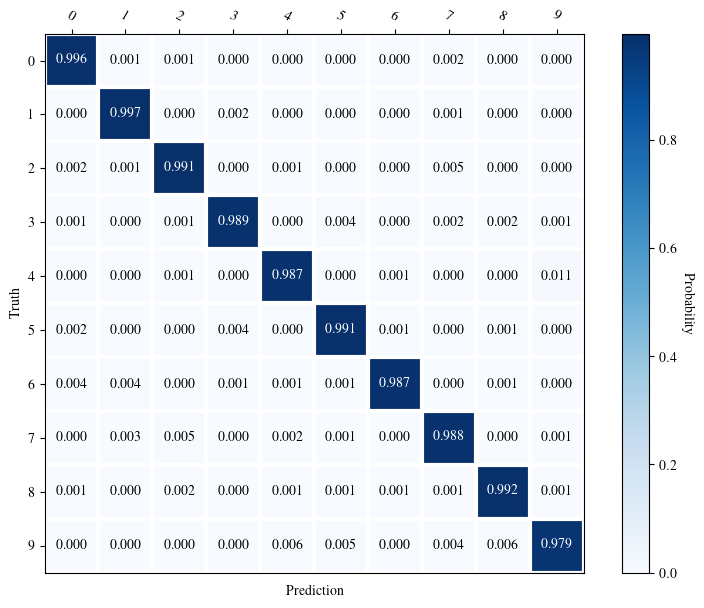

In [13]:
## Confusion Matrix
# Converting list of tensors to list of integers
preds = [pred for pred in predicted_all]
truths = [tru for tru in labels_all]

con_mat = sklearn.metrics.confusion_matrix(truths,preds,normalize='true')
axlabels= [ str(num) for num in np.arange(10)]

fig, ax = plt.subplots(figsize=(10,7))
im, cbar = cm.heatmap(con_mat, axlabels, axlabels, ax=ax,cmap = 'Blues', cbarlabel="Probability")
plt.ylabel("Truth")
plt.xlabel("Prediction")
texts = cm.annotate_heatmap(im, valfmt="{x:.3f}")
fig1 = plt.gcf()
#fig1.savefig("../figs/conf_mat.png")

## Class-specific accuracy

In [14]:
classes = [i for i in range(10)]
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in loaders['test']:
        images, labels = data
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[int(label.numpy())] += 1
            total_pred[int(label.numpy())] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5d} is {accuracy:.3f} %')

Accuracy for class:     0 is 99.592 %
Accuracy for class:     1 is 99.736 %
Accuracy for class:     2 is 99.128 %
Accuracy for class:     3 is 98.911 %
Accuracy for class:     4 is 98.676 %
Accuracy for class:     5 is 99.103 %
Accuracy for class:     6 is 98.747 %
Accuracy for class:     7 is 98.833 %
Accuracy for class:     8 is 99.179 %
Accuracy for class:     9 is 97.919 %


# Missclassifications

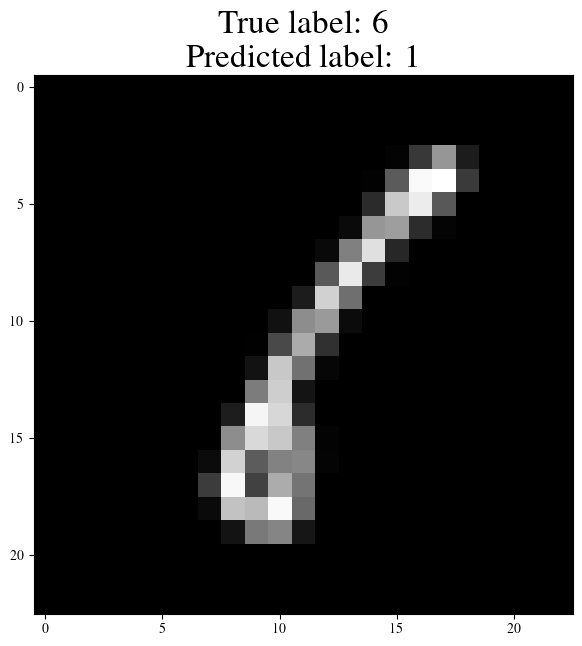

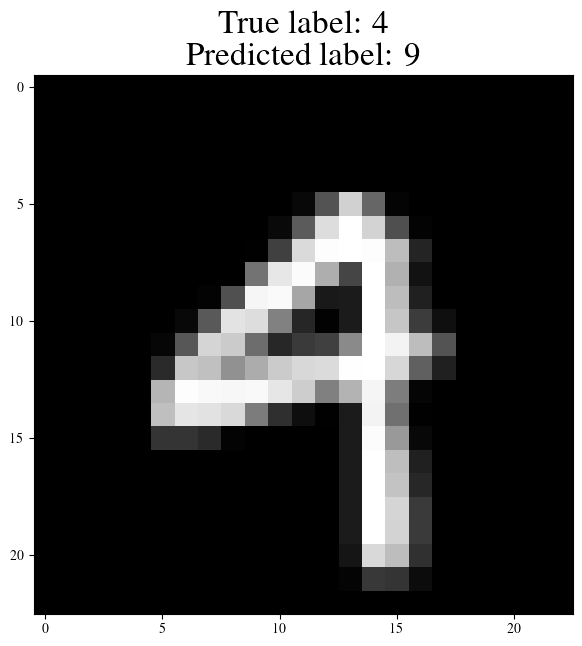

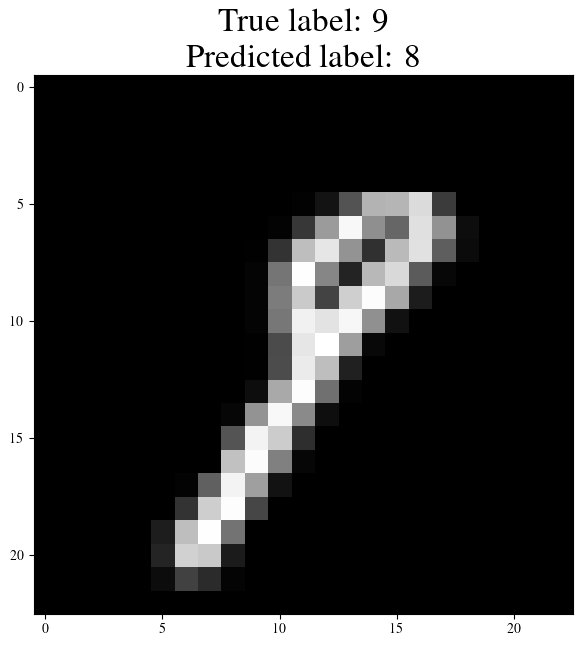

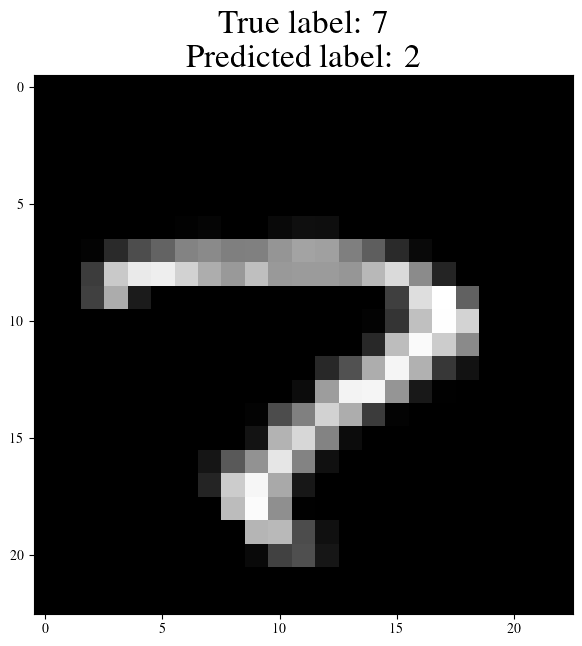

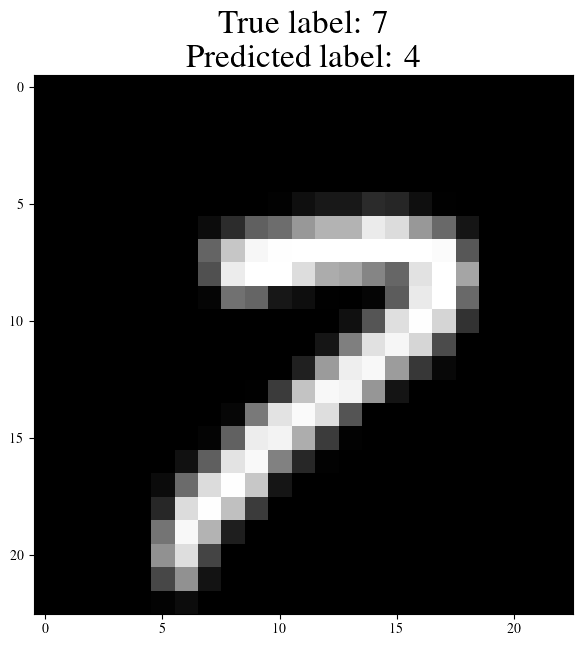

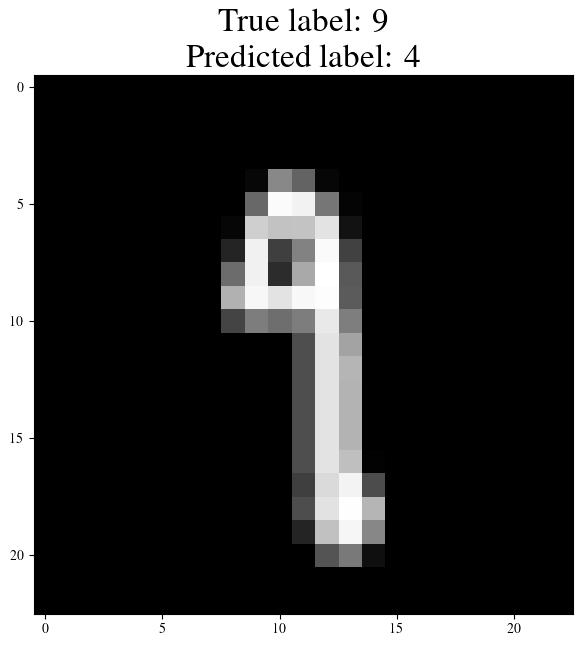

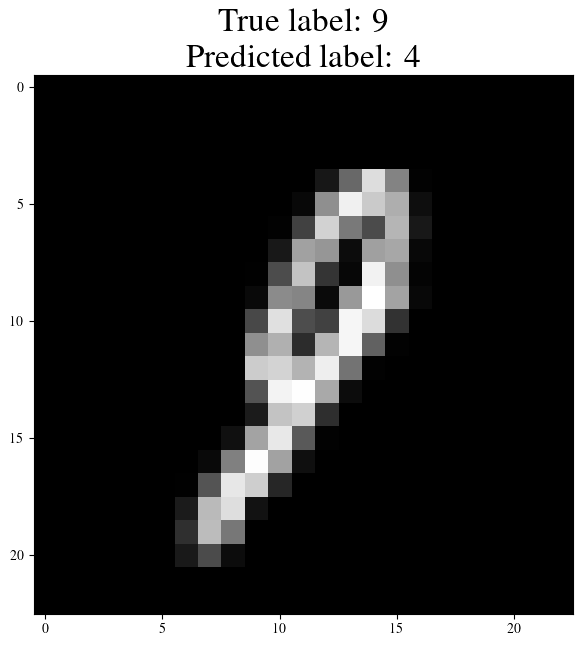

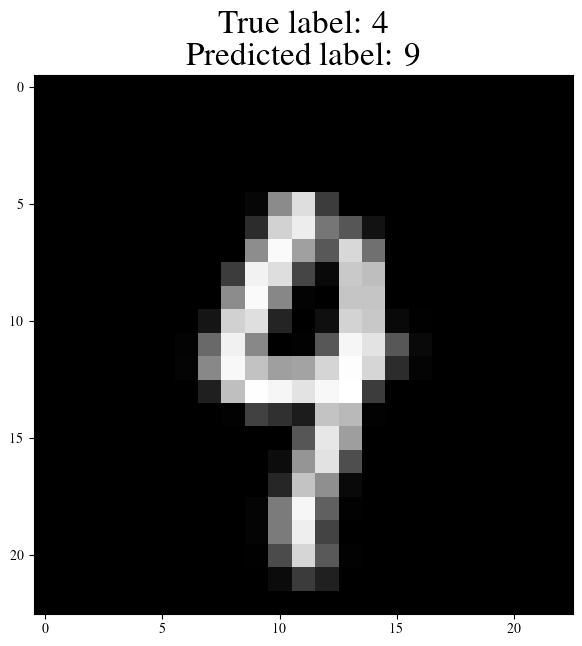

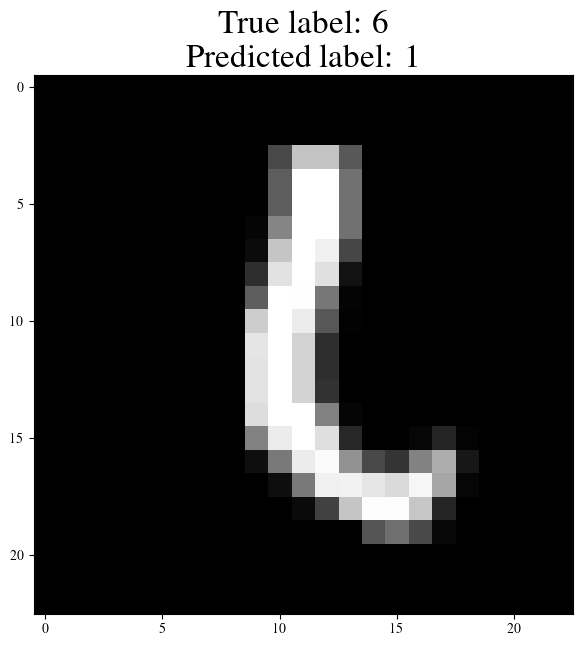

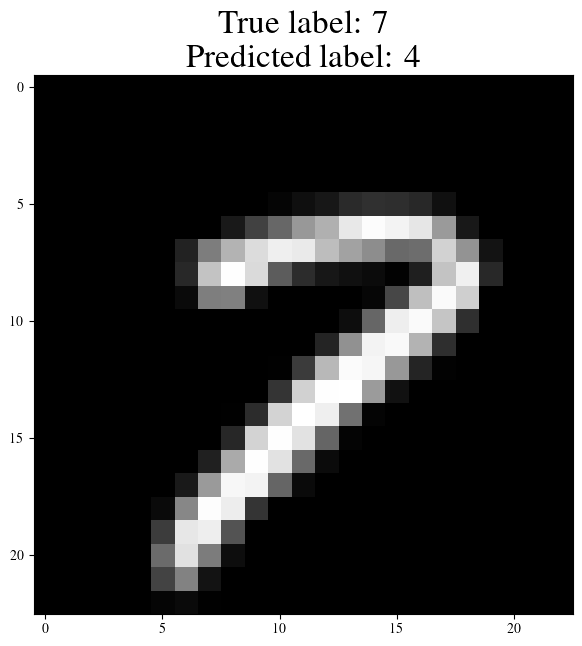

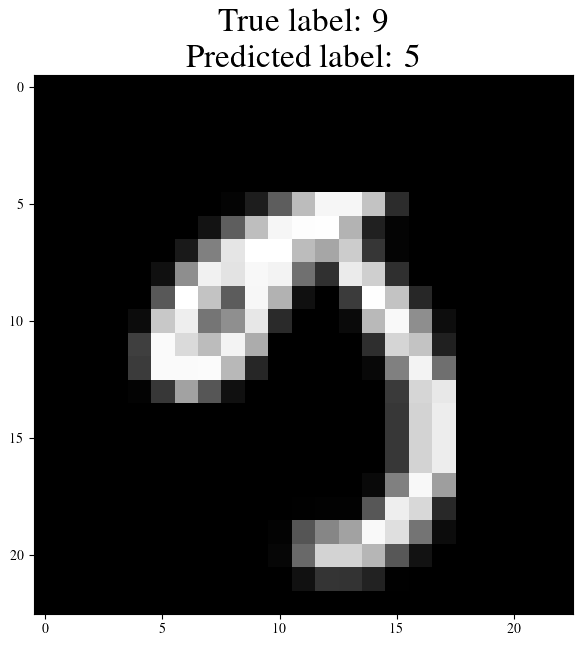

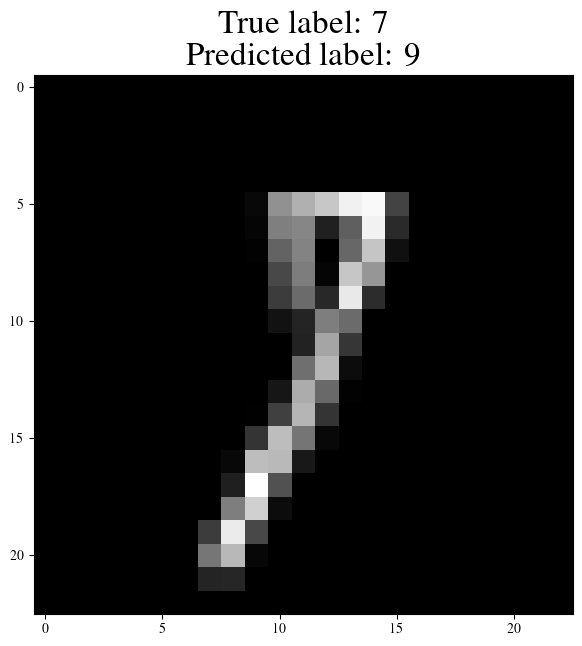

In [48]:
#index = 1
FIG_FOLDER = "/Users/jocelynornelas/iCloud Drive (Archive)/Desktop/UC Merced/Research/coded-aperture/slides_coded_aperture/images/"
cmap = 'gray'
for index in range(30,50):#len(incorrect_examples)):
    true_img = np.squeeze(incorrect_examples[index][0])
    true_lab = incorrect_examples[index][1]
    pred_lab = incorrect_examples[index][2]

    if true_lab in [9,4,6,7]:
        fig, axs = plt.subplots(1,1, figsize=(7,7))
        #axs = axs.ravel()
        axs.imshow(true_img, cmap=cmap)
        #axs[1].imshow(img, cmap=cmap)
        axs.set_title(f"True label: {true_lab}\nPredicted label: {pred_lab}", fontsize=24)
        #axs[1].set_title(f"Predicted label: {pred_lab}", fontsize=16)
        fig.savefig(FIG_FOLDER + f"misclass_original_{index}.png")
        plt.show() 

In [17]:
# Save dataframe with misclassifications
df = pd.DataFrame(incorrect_examples, columns=['image_array', 'label', 'prediction'])
df.head()

,image_array,label,prediction
0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",4,2
1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",6,0
2,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",8,2
3,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2,7
4,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",5,3


In [18]:
print("Misclassifications in order:\n")
df.label.value_counts(normalize=True)

Misclassifications in order:



9    0.207921
4    0.128713
6    0.118812
7    0.118812
3    0.108911
2    0.089109
8    0.079208
5    0.079208
0    0.039604
1    0.029703
Name: label, dtype: float64

In [26]:
df[df.label == 9].prediction.value_counts(normalize=True)

8    0.285714
4    0.285714
5    0.238095
7    0.190476
Name: prediction, dtype: float64

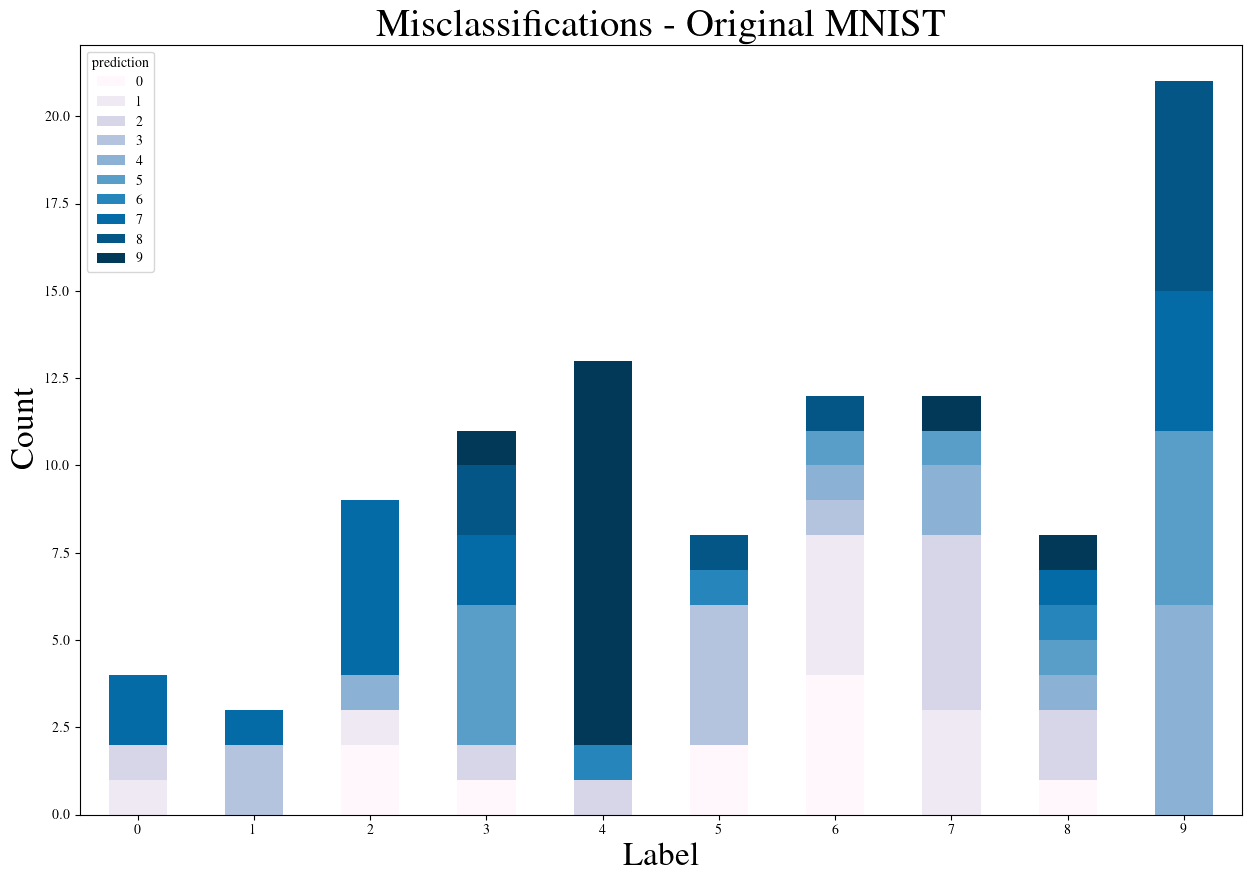

prediction  0  1  2  3  4  5  6  7  8   9
label                                    
0           0  1  1  0  0  0  0  2  0   0
1           0  0  0  2  0  0  0  1  0   0
2           2  1  0  0  1  0  0  5  0   0
3           1  0  1  0  0  4  0  2  2   1
4           0  0  1  0  0  0  1  0  0  11
5           2  0  0  4  0  0  1  0  1   0
6           4  4  0  1  1  1  0  0  1   0
7           0  3  5  0  2  1  0  0  0   1
8           1  0  2  0  1  1  1  1  0   1
9           0  0  0  0  6  5  0  4  6   0


In [34]:
fontsize = 28
crosstab_misclass = pd.crosstab(df.label, df.prediction, margins=False)
crosstab_misclass.plot(kind="bar", stacked=True, rot=0, cmap="PuBu")
plt.ylabel("Count", fontsize=fontsize-4)
plt.xlabel("Label", fontsize=fontsize-4)
plt.title("Misclassifications - Original MNIST", fontsize=fontsize)
#plt.savefig("../figs/misclassifications_counts_original_mnist.png")
plt.show()
print(crosstab_misclass)